In [2]:
# Import necessary libraries

# These are already installed in the developer environment
# All you need is the import statements

import descarteslabs as dl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import json
from IPython.display import GeoJSON

# These require installation via the terminal first
# I used 'conda install' and then each library name

import rasterio
from rasterstats import zonal_stats
from rasterio.plot import show
import geopandas as gpd

In [5]:
# The first step is to Import and filter the GeoJSON food desert polygons

# Open local GeoJSON file then create new python object using json.load
with open('foodDesertsByCensusTract.geojson') as desertsdata_file:
    desertsdata_loaded = json.load(desertsdata_file)

In [6]:
# Find those tracts flagged for both low income and low food access

newfeatures = [] # Creating a new empty array gives us a place to store the features

# LA1and10 is a binary field containing a 1 if the tract is flagged for low access at 
#   1 mile in urban areas and 
#   10 miles in rural areas

# LowIncomeTracts is a binary field containing a 1 if the tract is flagged for low income
for feature in desertsdata_loaded["features"]:
    if feature['properties']['LA1and10'] == 1 and feature['properties']['LowIncomeTracts'] == 1:
        newfeatures.append(feature)

In [7]:
# By copying the original GeoJSON data I can carry over all of the information
#   and then replace features with the array of flagged census tract features
flaggedtracts = desertsdata_loaded.copy()
flaggedtracts['features'] = newfeatures

In [8]:
# Preview map of the resulting polygon features
GeoJSON(flaggedtracts)

<IPython.display.GeoJSON object>

In [9]:
# Next step: downloading population density data as an image and as an NumPy array

# First we need to search for the data using the Descartes Labs metadata API
#   the string within the search is the product id, found on the product catalog listing
scns = dl.metadata.search('5151d2825f5e29ff129f86d834946363ff3f7e57:CIESIN:popden:v0')

# The search returns one matching scene, so next we need to extract the scene id
#   which gets passed to the raster service to get the corresponding data
#   Note: a product can have many scenes, but a scene is part of only one product.

id = scns['features'][0]['id']

In [10]:
# Since we want to constrain our analysis to just New Mexico for now
#   we use the places API to get the geometry of the state
geometry = dl.places.shape('new-mexico')

In [12]:
# Now we are ready to make a request to the raster service,
#  and pass the geometry of New Mexico as the cutline

# This returns a NumPy array and a metadata object
popden_raster_array, meta = dl.raster.ndarray(id,
              bands=["popden"],
              cutline=geometry)

# While this returns a tiff and saves it to the local environment
popden_tiff = dl.raster.raster(id,bands=["popden"],
              cutline=geometry,
              save='true')
# I renamed the saved tiff to 'popden.tiff' to make it easier to work with

In [13]:
# Using the rasterio library to open the tif facilitates plotting and stats
popden = rasterio.open('popden.tif')

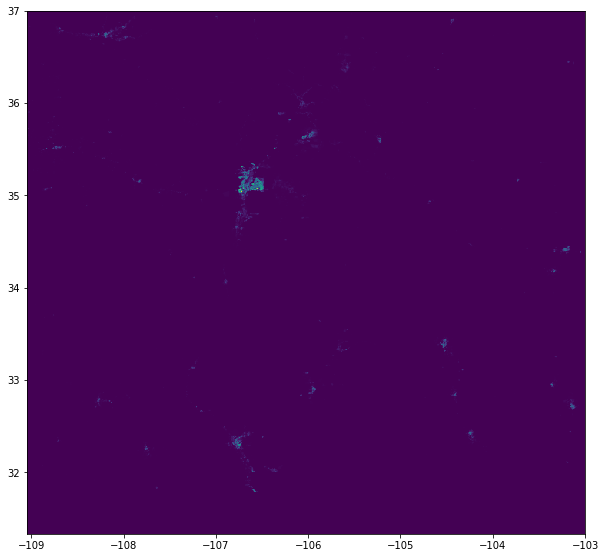

In [21]:
# Now we can view a plot of the tiff raster data
plt.figure(figsize=[10, 10])
show((popden, 1))

# the axes show coordinates, but they can be turned off using plt.axis('off')

In [18]:
# To add our food deserts polygons we need to conver the GeoJSON data to a GeoDataFrame
gdf_fooddeserts = gpd.GeoDataFrame.from_features(flaggedtracts['features'])

# We should also set the CRS to match the tiff file
print(popden.crs.data) # returns {'init': 'epsg:4326'}
gdf_fooddeserts.crs = {'init': 'epsg:4326', 'no_defs': True}

{'init': 'epsg:4326'}


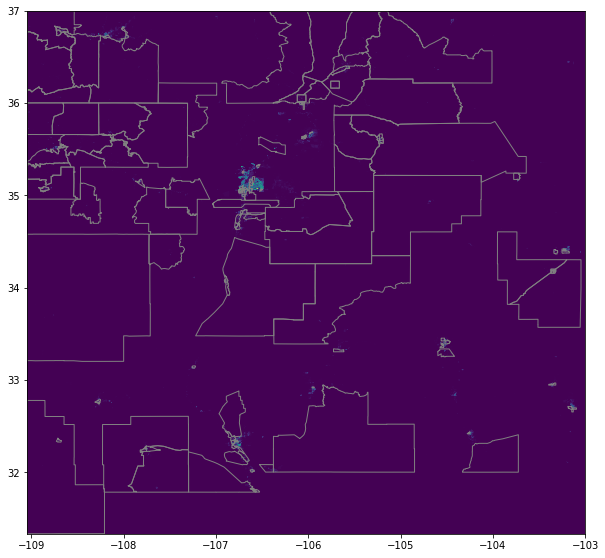

In [22]:
fig, ax = plt.subplots(figsize=[10, 10]) # the subplots format is needed to add our GeoDataFrame data
show((popden, 1), ax=ax)  

# Adding the overlayed polygons
gdf_fooddeserts.plot(ax=ax, facecolor='None', edgecolor='grey', linewidth=1)

In [25]:
# Next the goal is to find which of those flagged census tracts has the highest median population density
#   alternative questions could be pursued using other descriptive stats including
#   'min', 'max', 'mean', or 'majority'

# The zonal stats library requires an affine transformation for using vector data with NumPy raster arrays
#   the appropriate transformation can be found in the metadata returned by the dl raster service
geoaffine = meta["geoTransform"]

# Pass the NumPy raster array and the affine transform to zonal stats along with the GeoJSON
zs = zonal_stats(flaggedtracts, popden_raster_array, transform=geoaffine, stats=['max','median'])

# Note: the function above returns a deprecation warning, but the suggested alternative syntax 
#   returns an error: DotList' object has no attribute 'from_gdal'

/opt/conda/lib/python3.6/site-packages/rasterstats/main.py:131: DeprecationWarning: GDAL-style transforms will disappear in 1.0. Use affine=Affine.from_gdal(*transform) instead
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/opt/conda/lib/python3.6/site-packages/rasterstats/main.py:165: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  np.issubdtype(fsrc.array.dtype, float)


In [26]:
# To compare just the median values we get the sequence of medians from the list returned by zonal stats
seq = [x['median'] for x in zs]

# The zonal stats function returns the list of values in the same order as the GeoJSON features,
#   so we need to get the position of the maximum value in the seq
m = max(seq)
print(m)
[i for i, j in enumerate(seq) if j == m]
# Prints maximum value 4636.0 and returns position [41]

4636.0


[41]

In [28]:
# The final step is to find the corresponding feature, which also has position 41
print(flaggedtracts['features'][41]['properties']['GEO_ID']) # prints 35001004734
GeoJSON(flaggedtracts['features'][41])

35001004734


<IPython.display.GeoJSON object>